This notebook is an analysis of the errors in relative free energy calculations from the Schrödinger JACS dataset:
> Wang, L., Wu, Y., Deng, Y., Kim, B., Pierce, L., Krilov, G., ... & Romero, D. L. (2015). Accurate and reliable prediction of relative ligand binding potency in prospective drug discovery by way of a modern free-energy calculation protocol and force field. Journal of the American Chemical Society, 137(7), 2695-2703.

http://doi.org/10.1021/ja512751q

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
# Read the Excel sheet
df = pd.read_excel('ja512751q_si_003.xlsx', sheet_name='ddG')

In [3]:
# Delete rows with summary statistics
rows_to_drop = list()
for i, row in df.iterrows():
    if str(df.loc[i,'Ligand1']) == 'nan':
        rows_to_drop.append(i)
print('dropping rows: {}'.format(rows_to_drop))
df = df.drop(index=rows_to_drop);

dropping rows: [330]


In [4]:
# Populate 'system' field for each entry
system = df.loc[0,'system']
for i, row in df.iterrows():
    if str(df.loc[i,'system']) == 'nan':
        df.loc[i, "system"] = system
    else:
        system = df.loc[i, "system"]

In [5]:
df

,system,Ligand1,Ligand2,exp_ddG,bennett_ddG,bennett_error,ccc_ddG,ccc_error,Unnamed: 8,Error_bar,abs_error_Bar,Unnamed: 11,Error_ccc,Abs_error_ccc,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,BACE,CAT-13b,CAT-17g,-0.62,0.36,0.11,-0.18,1.20,NaN,-0.98,0.98,0.9604,-0.44,0.44,0.1936,NaN,NaN
1,BACE,CAT-13a,CAT-17g,-0.90,-0.02,0.10,-0.26,0.92,NaN,-0.88,0.88,0.7744,-0.64,0.64,0.4096,NaN,NaN
2,BACE,CAT-13e,CAT-17g,0.22,1.50,0.11,1.40,0.81,NaN,-1.28,1.28,1.6384,-1.18,1.18,1.3924,NaN,NaN
3,BACE,CAT-4m,CAT-4c,1.30,0.78,0.10,0.98,0.46,NaN,0.52,0.52,0.2704,0.32,0.32,0.1024,NaN,NaN
4,BACE,CAT-13k,CAT-4d,0.59,-0.59,0.11,-0.76,0.51,NaN,1.18,1.18,1.3924,1.35,1.35,1.8225,NaN,NaN
5,BACE,CAT-24,CAT-17e,1.33,1.98,0.08,1.87,0.36,NaN,-0.65,0.65,0.4225,-0.54,0.54,0.2916,NaN,NaN
6,BACE,CAT-13g,CAT-17g,-0.65,0.86,0.15,0.98,0.64,NaN,-1.51,1.51,2.2801,-1.63,1.63,2.6569,NaN,NaN
7,BACE,CAT-13d,CAT-13h,0.84,1.46,0.10,1.24,0.92,NaN,-0.62,0.62,0.3844,-0.40,0.40,0.1600,NaN,NaN
8,BACE,CAT-13a,CAT-17i,-0.63,-0.76,0.11,-0.52,0.92,NaN,0.13,0.13,0.0169,-0.11,0.11,0.0121,NaN,NaN
9,BACE,CAT-4m,CAT-13j,0.42,-0.01,0.12,-0.24,0.59,NaN,0.43,0.43,0.1849,0.66,0.66,0.4356,NaN,NaN


In [6]:
def bootstrap_statistic(errors, ci=0.95, statistic='rmse', nbootstrap = 1000):
    """Compute mean and confidence intervals of specified statistic.
    
    Parameters
    ----------
    errors : ndarray of shape (N,)
        The errors to bootstrap
    ci : float, optional, default=0.95
        Interval for CI
    statistic : str, optional, default='rmse'
        Statistic to compute; one of ['rmse', 'mue']
    nbootstrap : int, optional. default=10000
        Number of bootstrap samples
        
    Returns
    -------
    mean : float
        The mean statistic for the whole dataset
    stderr : float
        The standard error
    low, high : float
        Low and high ends of CI    
    """
    
    def compute_statistic(errors, statistic):
        if statistic == 'rmse':
            return np.sqrt(np.mean(errors**2))
        elif statistic == 'mue':
            return np.mean(np.abs(errors))
        else:
            raise Exception("unknown statistic '{}'".format(statistic))
            
    sample_size = len(errors)
    rmse_n = np.zeros([nbootstrap], np.float64)
    for replicate in range(nbootstrap):
        bootstrapped_sample = np.random.choice(np.arange(sample_size), size=[sample_size])
        rmse_n[replicate] = compute_statistic(errors[bootstrapped_sample], statistic)
        
    rmse_n = np.sort(rmse_n)
        
    rmse = compute_statistic(errors, statistic)
    drmse = np.std(rmse_n)
    
    low_frac = (1.0-ci)/2.0
    high_frac = 1.0 - low_frac
    rmse_low = rmse_n[int(np.floor(nbootstrap*low_frac))]
    rmse_high = rmse_n[int(np.ceil(nbootstrap*high_frac))]

    return rmse, drmse, rmse_low, rmse_high

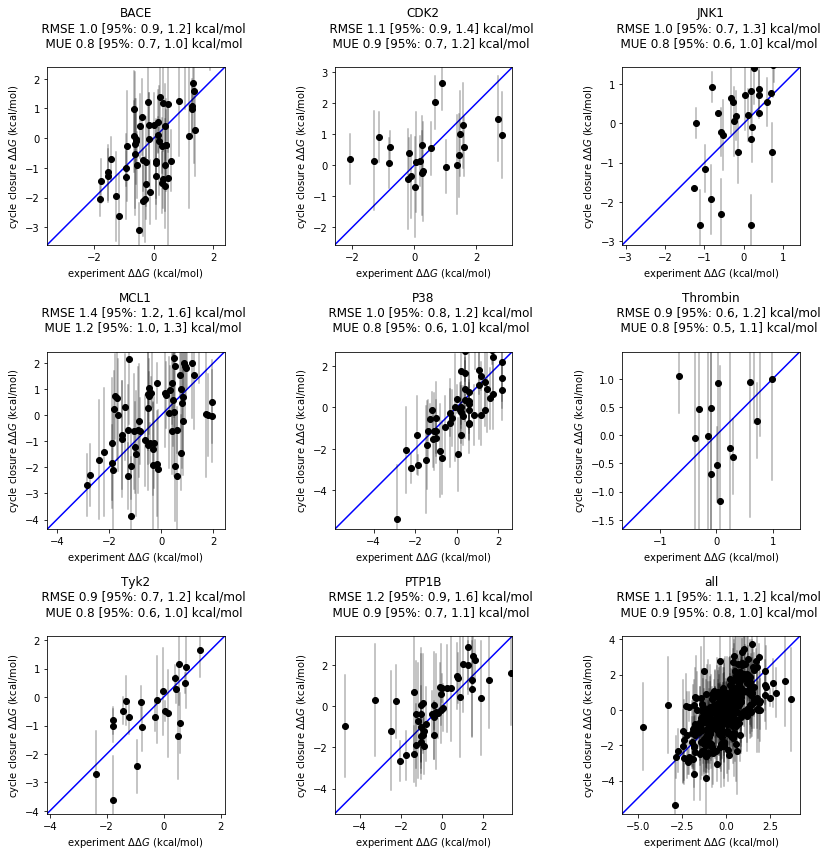

In [7]:
# Collect data by system
def plot_data(rows):
    exp_ddg = rows['exp_ddG'].values
    ccc_ddg = rows['ccc_ddG'].values
    ccc_error = rows['ccc_error'].values
    error = rows['Error_ccc'].values
    xmin = min(exp_ddg.min(), ccc_ddg.min()) - 0.5
    xmax = min(exp_ddg.max(), ccc_ddg.max()) + 0.5
    plt.xlabel('experiment $\Delta \Delta G$ (kcal/mol)');
    plt.ylabel('cycle closure $\Delta \Delta G$ (kcal/mol)');
    plt.plot([xmin, xmax], [xmin, xmax], 'b-');
    plt.plot(exp_ddg, ccc_ddg, 'ko');
    plt.plot([exp_ddg, exp_ddg], [ccc_ddg-2*ccc_error, ccc_ddg+2*ccc_error], 'k-', alpha=0.3);

    rmse, drmse, rmse_low, rmse_high = bootstrap_statistic(error, statistic='rmse')
    mue, dmue, mue_low, mue_high = bootstrap_statistic(error, statistic='mue')
    title = """{}
    RMSE {:.1f} [95%: {:.1f}, {:.1f}] kcal/mol
    MUE {:.1f} [95%: {:.1f}, {:.1f}] kcal/mol
    """.format(system, rmse, rmse_low, rmse_high, mue, mue_low, mue_high)
    plt.title(title);
    
    plt.axis('square');
    plt.xlim(xmin, xmax);
    plt.ylim(xmin, xmax);

systems = df['system'].unique()
nsystems = len(systems)
nx = int(np.ceil(np.sqrt(nsystems)))
ny = int(np.ceil(np.sqrt(nsystems)))
fig = plt.figure(figsize=[12,12])
for plot_index, system in enumerate(systems):
    plt.subplot(ny, nx, plot_index+1)
    rows = df.query("system == '{}'".format(system))
    plot_data(rows)
    
plt.subplot(ny, nx, nsystems+1)
system = 'all'
plot_data(df)
    
fig.tight_layout()
fig.savefig('jacs-analysis.pdf');